# import modules

In [1]:
import numpy as np
import pandas as pd
import logging
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import pandas as pd
import numpy as np
import logging

# Configure logging to display messages to the console while the function runs
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# functions

In [3]:
# clean_data function
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Transform datatypes:
        -transform 'PurchDate' to datetime format
    Change values:
        - 'color' and 'Top Three American Names' use 'unknown' category instead of Nan
        - 'Transmission' correct spelling Manual to MANUAL
         
    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    
    """
    # unix timestamp to datetime
    df.loc[:, 'PurchDate'] = pd.to_datetime(df.loc[:, 'PurchDate'], unit='s')
    
    # clean values Transmission
    df.loc[:,'Transmission'] = df.loc[:,'Transmission'].str.upper() #correct spelling
   
    return df

In [4]:
def nan_handling(df_train, df):
    """Returns a clean DataFrame without NaN Values.
    This function fills missing values in categorical columns with predefined values,
    uses the mode for selected categorical columns, and fills numerical columns with the median from df_train.
    """
    logger.debug("Starting NaN handling process...")
    
    # Ensure full copy to avoid SettingWithCopyWarning
    df = df.copy(deep=True)

    # Fill predefined categorical columns
    fill_values_cat = {
        'TopThreeAmericanName': 'OTHER', 'Color': 'NOT AVAIL', 'Trim': 'OTHER',
        'SubModel': 'OTHER', 'WheelType': 'OTHER', 'WheelTypeID': 0,
        'AUCGUART': 'YELLOW', 'Auction': 'NOT AVAIL', 'Make': 'NOT AVAIL',
        'Model': 'NOT AVAIL', 'BYRNO': 'NOT AVAIL', 'VNZIP1': 'NOT AVAIL',
        'VNST': 'NOT AVAIL'
    }

    #logger.debug("Filling categorical columns with predefined values...")
    for col, value in fill_values_cat.items():
        if col in df.columns:
            missing_before = df[col].isna().sum()
            df.loc[:, col] = df[col].copy().fillna(value)
            missing_after = df[col].isna().sum()
            replaced = missing_before - missing_after
            #logger.debug(f"Replaced {replaced} missing values in '{col}' with '{value}'")

    # Handle TopThreeAmericanName based on Make
    make_to_tan = {
        'CHRYSLER': ['JEEP', 'DODGE', 'CHRYSLER'],
        'FORD': ['MERCURY', 'LINCOLN', 'FORD'],
        'GM': ['SATURN', 'PONTIAC', 'OLDSMOBILE', 'CHEVROLET', 'BUICK', 'GMC']
    }

    #logger.info("Filling 'TopThreeAmericanName' based on 'Make' column...")
    for tan, makes in make_to_tan.items():
        if 'Make' in df.columns and 'TopThreeAmericanName' in df.columns:
            mask = df['Make'].isin(makes) & df['TopThreeAmericanName'].isna()
            missing_before = mask.sum()
            df.loc[mask, 'TopThreeAmericanName'] = tan
            missing_after = df['TopThreeAmericanName'].isna().sum()
            replaced = missing_before - missing_after
            #logger.debug(f"Replaced {replaced} missing values in 'TopThreeAmericanName' with '{tan}'")

    # Fill Nationality based on TopThreeAmericanName
    if 'Nationality' in df.columns and 'TopThreeAmericanName' in df.columns:
        american_mask = df['TopThreeAmericanName'].isin(['CHRYSLER', 'FORD', 'GM'])
        missing_before = df['Nationality'].isna().sum()
        df.loc[american_mask, 'Nationality'] = 'AMERICAN'
        df.loc[:, 'Nationality'] = df['Nationality'].copy().fillna('OTHER')
        missing_after = df['Nationality'].isna().sum()
        replaced = missing_before - missing_after
        #logger.debug(f"Replaced {replaced} missing values in 'Nationality' with 'OTHER'")

    # Fill mode for selected categorical columns
    mode_columns = ['Transmission', 'Size', 'PRIMEUNIT', 'IsOnlineSale']
    #logger.debug("Filling with mode for selected categorical columns...")
    for col in mode_columns:
        if col in df.columns:
            missing_before = df[col].isna().sum()
            mode_value = df_train[col].mode()[0] if not df_train[col].mode().empty else 'UNKNOWN'
            df.loc[:, col] = df[col].copy().fillna(mode_value)
            missing_after = df[col].isna().sum()
            replaced = missing_before - missing_after
            #logger.debug(f"Replaced {replaced} missing values in '{col}' with mode '{mode_value}'")

    # Fill median for numerical columns
    median_columns = [
        'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
        'VehBCost', 'WarrantyCost', 'VehYear', 'VehicleAge', 'VehOdo'
    ]

    #logger.debug("Filling numerical columns with median values...")
    for col in median_columns:
        if col in df.columns:
            missing_before = df[col].isna().sum()
            median_value = df_train[col].median() if not df_train[col].isna().all() else 0
            df.loc[:, col] = df[col].copy().fillna(median_value)
            missing_after = df[col].isna().sum()
            replaced = missing_before - missing_after
            #logger.debug(f"Replaced {replaced} missing values in '{col}' with median value {median_value}")

    logger.info("NaN handling process completed.")
    return df


# Train Test Split

In [5]:
# perform train-test-split
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data_train.csv')

features = df.drop('IsBadBuy', axis=1)
target = df.loc[:,'IsBadBuy']

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)


df_features_train = clean_data(features_train)
df_features_train = nan_handling(features_train, features_train)

df_features_test = clean_data(features_test)
df_features_test = nan_handling(features_train, features_test)


/home/jovyan/.virtualenvs/training_env/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
2025-03-07 16:15:07,045 - DEBUG - Starting NaN handling process...
2025-03-07 16:15:07,179 - INFO - NaN handling process completed.
/home/jovyan/.virtualenvs/training_env/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, 

# Feature Engineering

In [6]:
# create new features

features = df_features_train

cols_acquisition = ['MMRAcquisitionAuctionAveragePrice',
                    'MMRAcquisitionAuctionCleanPrice',
                    'MMRAcquisitionRetailAveragePrice',
                    'MMRAcquisitonRetailCleanPrice']
cols_current = ['MMRCurrentAuctionAveragePrice',
                'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice',
                'MMRCurrentRetailCleanPrice']

features.loc[:,'miles_per_year'] = round((features.loc[:,'VehOdo'] / features.loc[:,'VehicleAge']),1)
features.loc[:,'value_lost'] = (features.loc[:,cols_acquisition]).median(axis=1) - (features.loc[:,cols_current]).median(axis=1)
features.loc[:,'purchase_month'] = features.loc[:,'PurchDate'].dt.month
features.loc[:,'purchase_weekday'] = features.loc[:,'PurchDate'].dt.weekday


# transform Values / Label Encoding
di = {'YES': 1, 'NO': 0,
     'GREEN': 1, 'YELLOW': 0, 'RED': 0 }

features.loc[:,'PRIMEUNIT'] = features.loc[:,'PRIMEUNIT'].replace(di)

features.loc[:,'guaranty'] = features.loc[:,'AUCGUART'].replace(di)
features.loc[:,'guaranty'] = pd.to_numeric(features.loc[:,'guaranty'])


# reduced features set
features = features.drop(labels=['Trim', 'Model', 'SubModel', 'BYRNO'], axis=1) #drop because of high variance in values

features = features.drop(labels=['WheelType','VNZIP1','Nationality', 'AUCGUART', 'PurchDate'], axis=1) #drop because is redundand

features.head()

,Auction,VehYear,VehicleAge,Make,Color,Transmission,WheelTypeID,VehOdo,Size,TopThreeAmericanName,...,PRIMEUNIT,VNST,VehBCost,IsOnlineSale,WarrantyCost,miles_per_year,value_lost,purchase_month,purchase_weekday,guaranty
21430,OTHER,2004,5,CHEVROLET,GREEN,AUTO,2.0,71041,VAN,GM,...,0,MS,4700.0,0,4622,14208.2,222.5,6,3,0
53433,OTHER,2007,2,KIA,SILVER,AUTO,2.0,63941,COMPACT,OTHER,...,0,CO,5255.0,0,533,31970.5,202.0,9,3,0
13278,OTHER,2006,3,PONTIAC,WHITE,AUTO,1.0,74180,MEDIUM,GM,...,0,CA,7305.0,0,1272,24726.7,766.0,7,1,0
29356,MANHEIM,2005,4,GMC,GREY,AUTO,1.0,61522,MEDIUM SUV,GM,...,0,FL,9300.0,0,1020,15380.5,0.0,4,1,0
28157,MANHEIM,2007,3,FORD,RED,AUTO,1.0,94153,LARGE,FORD,...,0,NV,6955.0,1,1774,31384.3,957.5,10,3,0


In [7]:
def engineer_features(features):
    
    '''
    returns modified features DataFrame
    
    creation of new features:
    - Miles per Year
    - Value lost
    - Month of Purchase
    - Weekday of Purchase
    
    Label Encoding:
    - PRIMEUNIT
    - guaranty (based on AUCGUART)
    
    drop features:
    due to high variety:
    - 'Trim', 'Model', 'SubModel', 'BYRNO'
    
    due to redundance:
    - 'WheelType','VNZIP1','Nationality', 'AUCGUART', 'PurchDate'
    
    Args: 
        features (pd.DataFrame) : Dataframe with features
        
    Returns:
        features  (pd.DataFrame) : cleaned DataFrame
    
    '''
    
    #########
    # create new features
    
    cols_acquisition = ['MMRAcquisitionAuctionAveragePrice',
                    'MMRAcquisitionAuctionCleanPrice',
                    'MMRAcquisitionRetailAveragePrice',
                    'MMRAcquisitonRetailCleanPrice']
    cols_current = ['MMRCurrentAuctionAveragePrice',
                'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice',
                'MMRCurrentRetailCleanPrice']
    
    features.loc[:,'miles_per_year'] = round((features.loc[:,'VehOdo'] / features.loc[:,'VehicleAge']),1)
    features.loc[:,'value_lost'] = (features.loc[:,cols_acquisition]).median(axis=1) - (features.loc[:,cols_current]).median(axis=1)
    features.loc[:,'purchase_month'] = features.loc[:,'PurchDate'].dt.month
    features.loc[:,'purchase_weekday'] = features.loc[:,'PurchDate'].dt.weekday
    
    #########
    # transform Values / Label Encoding
    
    di = {'YES': 1, 'NO': 0,
          'GREEN': 1, 'YELLOW': 0, 'RED': 0 }
    
    features.loc[:,'PRIMEUNIT'] = features.loc[:,'PRIMEUNIT'].replace(di)
    features.loc[:,'guaranty'] = features.loc[:,'AUCGUART'].replace(di)
    features.loc[:,'guaranty'] = pd.to_numeric(features.loc[:,'guaranty'])
   

    #########
    # reduced features set
    
    features = features.drop(labels=['Trim', 'Model', 'SubModel', 'BYRNO'], axis=1) #drop because of high variance in values
    
    features = features.drop(labels=['WheelType','VNZIP1','Nationality', 'AUCGUART', 'PurchDate'], axis=1) #drop because is redundand
    
    return features

# Baseline Model

In [8]:
# define num_cols and cat_cols
num_cols = ['VehYear',
            'VehicleAge',
            'VehOdo',
            'MMRAcquisitionAuctionAveragePrice',
            'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice',
            'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice',
            'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice',
            'MMRCurrentRetailCleanPrice',
            'VehBCost',
            'WarrantyCost'
            ]

cat_cols = ['Auction',
            'Make',
            'Model',
            'Trim',
            'SubModel',
            'Color',
            'Transmission',
            'WheelTypeID',
            'WheelType',
            'Nationality',
            'Size',
            'TopThreeAmericanName',
            'PRIMEUNIT',
            'AUCGUART',
            'BYRNO',
            'VNZIP1',
            'VNST',
            'IsOnlineSale'
           ]

date_cols = ['PurchDate']


In [9]:
# instantiate model

model = DecisionTreeClassifier(random_state=42, class_weight='balanced')


In [10]:
# build pipeline
model_baseline = Pipeline([('estimator', model)
                          ])

In [12]:
# fit pipeline on cleaned (and filtered) training set

# # reduced features set
# cols= ['VehicleAge'
#        ,'VehOdo'
#        ,'VehBCost'
#        ,'WarrantyCost'
#        ]

features_train_baseline = df_features_train.loc[:,num_cols]
features_test_baseline = df_features_test.loc[:,num_cols]


#fit model on train data
model_baseline.fit(features_train_baseline, target_train)


Pipeline(steps=[('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

2025-03-07 16:16:43,556 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x74e44a12cd00>
2025-03-07 16:16:43,557 - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x74e44a12cd00> on colorbar
2025-03-07 16:16:43,558 - DEBUG - Setting pcolormesh


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5716
           1       0.21      0.20      0.21       846

    accuracy                           0.80      6562
   macro avg       0.55      0.54      0.55      6562
weighted avg       0.80      0.80      0.80      6562



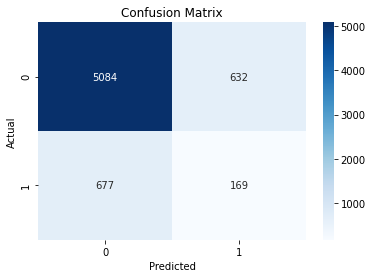

In [14]:
# predict and evaluate on test set

target_test_baseline_pred = model_baseline.predict(features_test_baseline)
print(classification_report(target_test, target_test_baseline_pred, zero_division=0))

# visualise confusion matrix

cm = confusion_matrix(target_test, target_test_baseline_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()